In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import math
import warnings
import os 
import pytesseract
from pytesseract import Output
warnings.filterwarnings(action= 'ignore')

In [3]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.01 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

In [4]:
def get_perspective(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.figure(figsize=(16,12))
    plt.subplot(121),plt.imshow(img), plt.title('Original')
    plt.subplot(122), plt.imshow(gray,'gray'), plt.title('gray scale image')
    
    ret, thresh = cv2.threshold(gray, 127,255,0)
   
    bfilter = cv2.bilateralFilter(gray, 20,30,30)
    plt.figure(figsize=(16,12))
    plt.subplot(121),plt.imshow(thresh,'gray'), plt.title('binary thresh')
    plt.subplot(122), plt.imshow(bfilter,'gray'), plt.title('bilateralFilter')
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    biggest = biggest_contour(contours)

    cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)
    plt.subplot(122), plt.imshow(img), plt.title('Contour border')

    mask = np.zeros(gray.shape, np.uint8)
    new_image = cv2.drawContours(mask, [biggest], -1,255, -1)
    new_image = cv2.bitwise_and(img, img, mask=mask)
    plt.figure(figsize=(16,12))
    plt.subplot(121), plt.imshow(new_image), plt.title('mask')

    (x,y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = img[x1:x2+1, y1:y2+1]
    plt.subplot(122), plt.imshow(cropped_image), plt.title('cropped image')

    # Pixel values in the original image
    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    max_width = max(int(bottom_width), int(top_width))
    max_height = max(int(right_height*0.8), int(left_height*0.8))
    #     max_height = int(max_width * 1.414)  # for A4

    # Desired points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformation
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(new_image, matrix, (max_width, max_height))
    plt.figure(figsize=(8,6))
    plt.imshow(img_output), plt.title('Warped image')
    plt.tight_layout()
    return img_output

        

In [5]:
def ocr(img1, img2):
    if img1 is None or img2 is None:
        raise ValueError("One of the images is None. Please check the image paths and formats.")
    regions = {
        "id": (img1[2000:2250, 1250:2800]),
        "fname": (img1[690:900, 2250:2800]),
        "lname": (img1[900:1150, 1600:2720]),
        "address": (img1[1200:1700, 900:2700]),
        "bdate": (img1[1900:2200, 220:580]),
        "number": (img1[2350:2650, 150:1000]),
        "id2": (img2[80:280, 1300:2250]),
        "pdate": (img2[80:280, 760:1240]),
        "job": (img2[300:470, 1950:2290]),
        "gender": (img2[720:920, 2000:2240]),
        "stutus": (img2[650:920, 900:1200]),
        "exdate": (img2[1100:1300, 840:1500])
    }
    results = {}
    for region_name, region_image in regions.items():
        plt.figure()
        gray = cv2.cvtColor(region_image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(gray, 0, 0, 1)
        _,th = cv2.threshold(gray, 100,250, cv2.THRESH_OTSU )

        if region_name == 'id' or region_name == 'id2':
            text = pytesseract.image_to_string(th, lang = 'ara_number')
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name =='number':
            _,th = cv2.threshold(gray, 40,50, cv2.THRESH_BINARY )
            text = pytesseract.image_to_string(th, lang ='eng',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name == 'fname': 
            text = pytesseract.image_to_string(th,lang='ara',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name == 'bdate' :   
            text = pytesseract.image_to_string(th, lang = 'ara_combined',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name == 'exdate':   
            text = pytesseract.image_to_string(th, lang = 'ara_combined',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name == 'pdate':
            text = pytesseract.image_to_string(th, lang = 'ara_combined',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        elif region_name == 'job' : 
            text = pytesseract.image_to_string(th,lang='ara',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
        else :
            _,th = cv2.threshold(gray, 200,250, cv2.THRESH_OTSU )
            text = pytesseract.image_to_string(th, lang = 'ara_combined',output_type=Output.STRING)
            results[region_name] = text
            plt.title(region_name)
            plt.imshow(th, 'gray')
            
    df = pd.DataFrame(results, index=[0]).T
    df = df.replace('\n', ' ', regex=True) 
    return df


In [8]:
def main():
    image_path1 = 'face.jpg'
    image_path2 = 'back.jpg'
    img1 = get_perspective(image_path1)
    img2 = get_perspective(image_path2)    
    df = ocr(img1, img2)
    print(df)

                                                         0
id                                       299 05 040100115 
fname                                                حسام 
lname                              علاءالدين ابراهيم فريد 
address  ۷اش فلسطين.ش جسرالسويس عرب الجسر عین سمس الفاهره 
bdate                                                ۱۹۹۹ 
number                                         J011782290 
id2                                        29905040100115 
pdate                                                   ۹ 
job                                                | طالب 
gender                                               اذكر 
stutus                                               اعزب 
exdate                                           ۰4/۰۹/۱۸ 


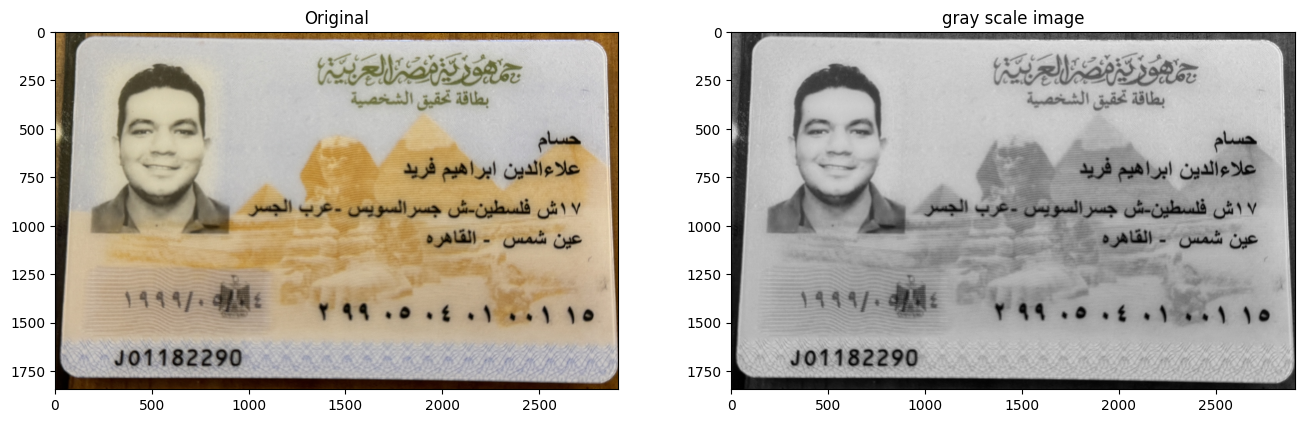

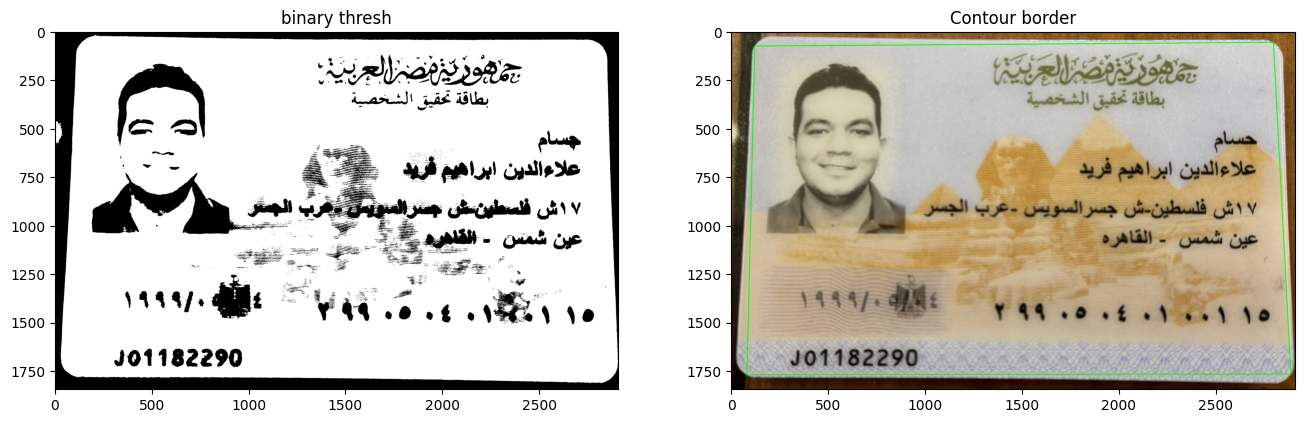

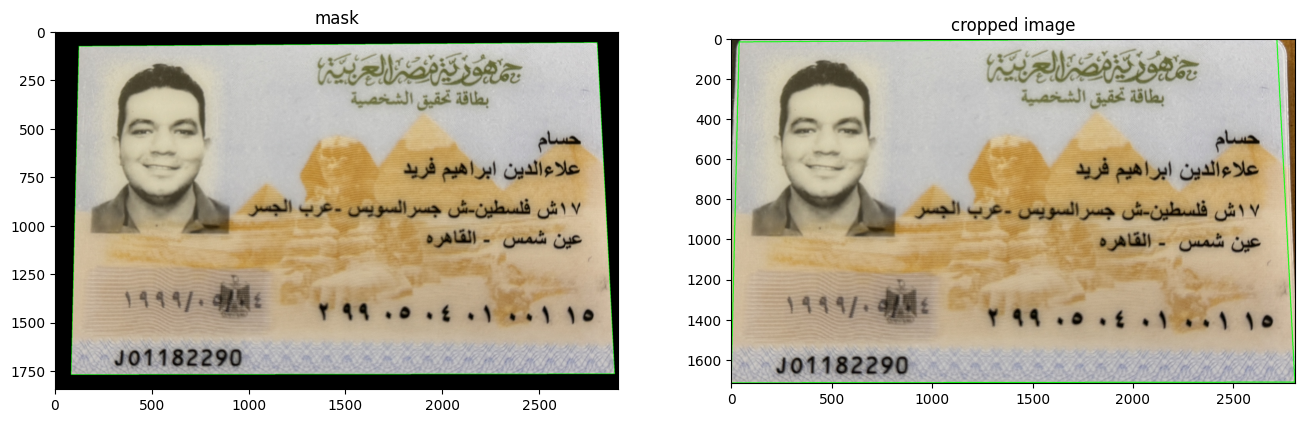

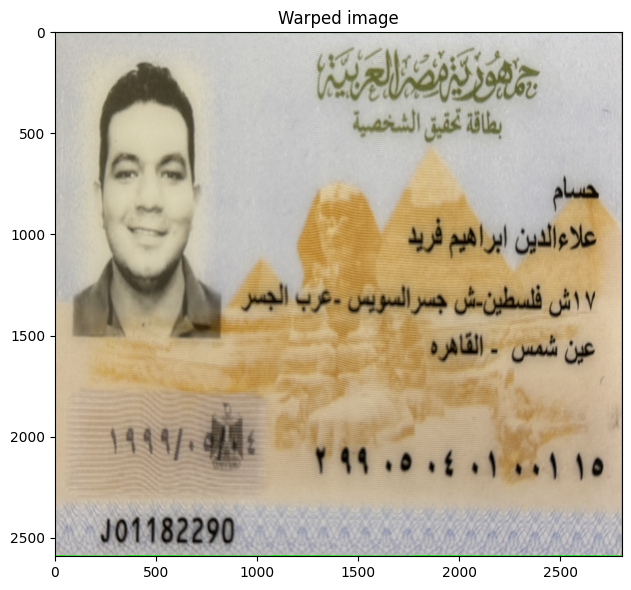

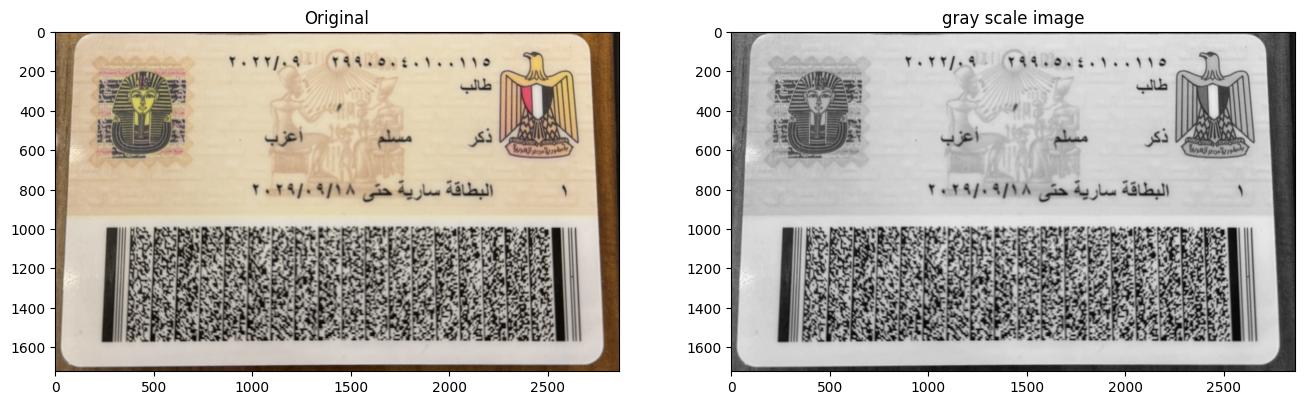

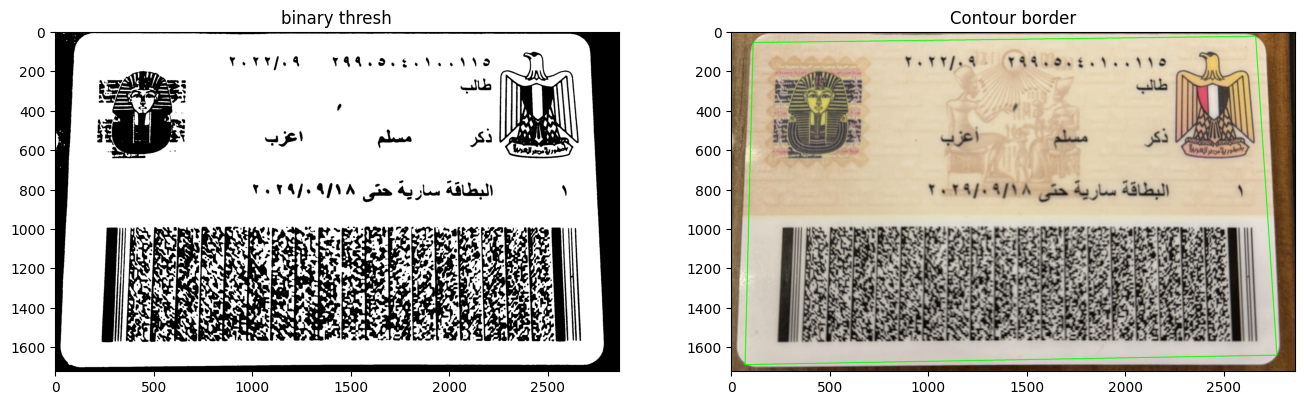

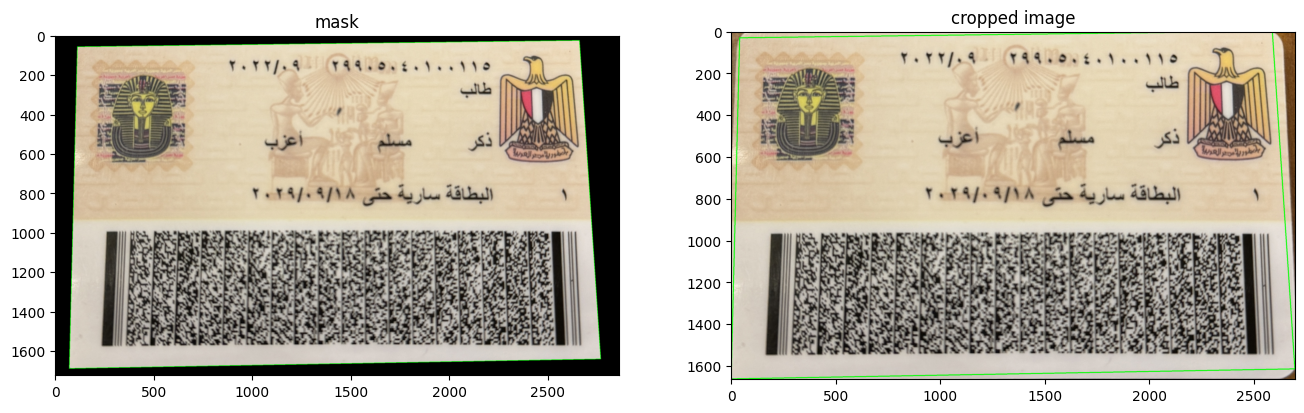

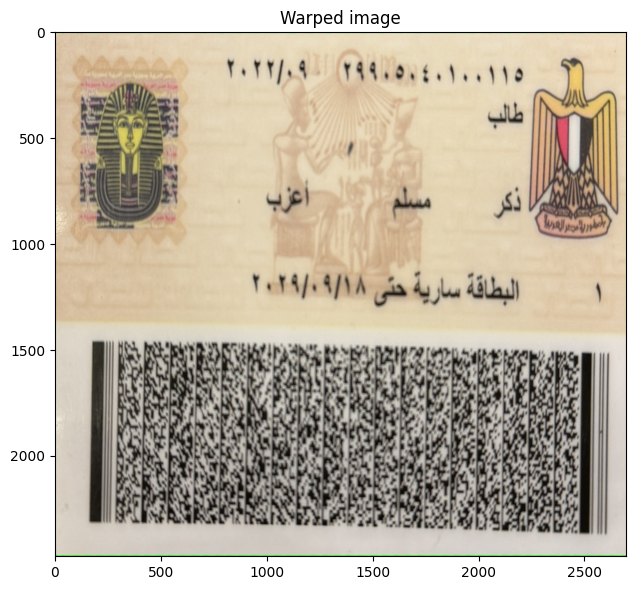

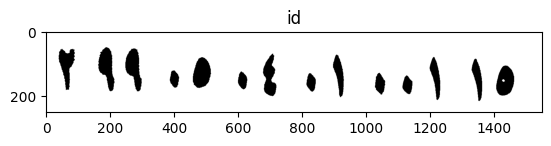

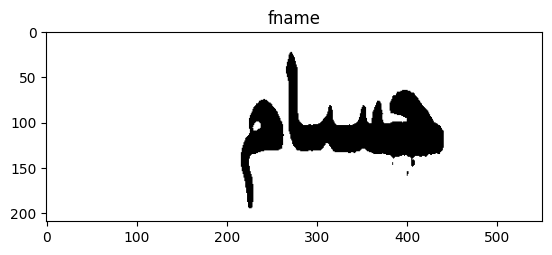

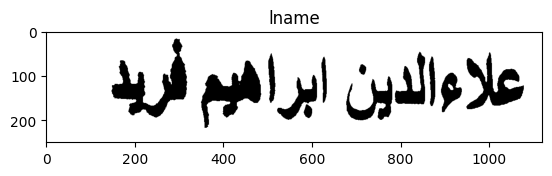

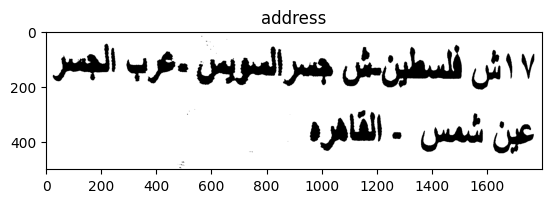

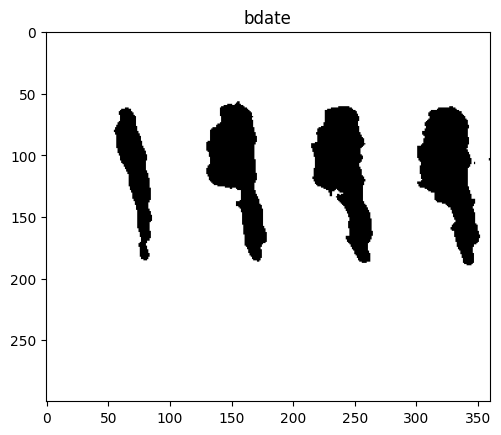

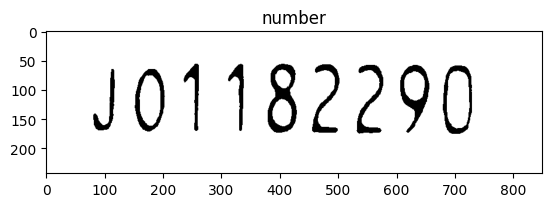

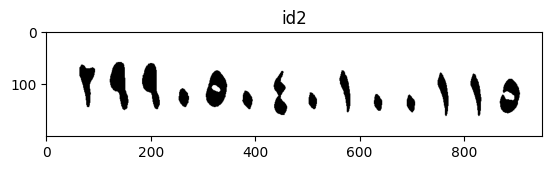

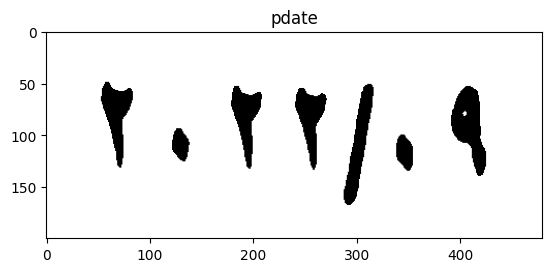

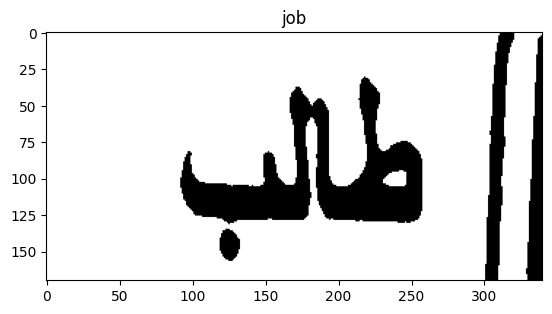

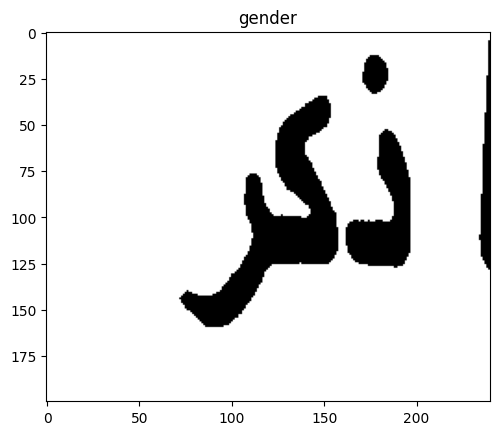

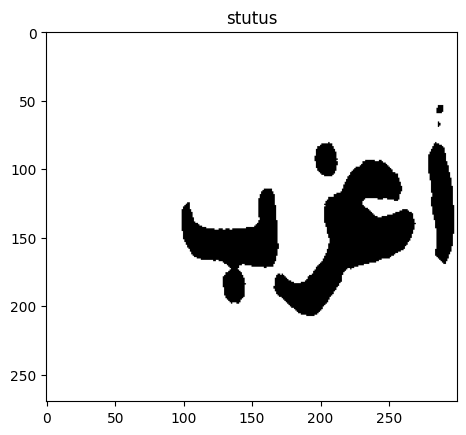

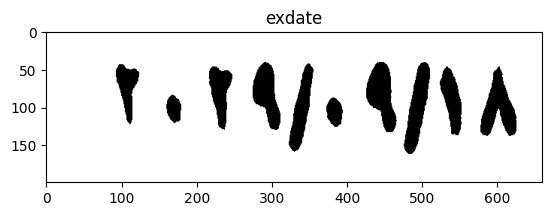

In [9]:
if __name__ == '__main__':
    main()
    